# Ray et al 2013 Plotting 
**Authorship:**
Adam Klie, *09/03/2022*
***
**Description:**
Notebook to benchmark MT and ST models against trained DeepBind models
***

In [1]:
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
%autoreload 2

import os
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import logging
import numpy as np
import pandas as pd
import eugene as eu

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

Global seed set to 13


GPU is available: True
Number of GPUs: 1
Current GPU: 0
GPUs: Quadro RTX 5000


In [2]:
eu.settings.dataset_dir = "/cellar/users/aklie/data/eugene/ray13"
eu.settings.output_dir = "/cellar/users/aklie/projects/EUGENe/EUGENe_paper/output/ray13"
eu.settings.logging_dir = "/cellar/users/aklie/projects/EUGENe/EUGENe_paper/logs/ray13"
eu.settings.config_dir = "/cellar/users/aklie/projects/EUGENe/EUGENe_paper/configs/ray13"
eu.settings.figure_dir = "/cellar/users/aklie/projects/EUGENe/EUGENe_paper/figures/ray13"
eu.settings.verbosity = logging.ERROR

# Performances from Alipanahi et al
Downloaded and will load in Supllementary Table 3 I think

In [3]:
# Read in the results from the ray13 analysis
sheet_name = ["Pearson of E-scores",
              "Spearman of E-scores",
              "Pearson of AUCs",
              "Spearman of AUCs",
              "Pearson of Z-scores",
              "Spearman of Z-scores",
              "Pearson with Intensities",
              "Spearman with intensities"]
performance_df = pd.DataFrame()
for sheet in sheet_name:
    x = pd.read_excel(os.path.join(eu.settings.dataset_dir, "41587_2015_BFnbt3300_MOESM53_ESM.xlsx"), sheet_name=sheet, skiprows=1, index_col=0)
    x["Metric"] = sheet.split(" ")[2]
    x["Correlation"] = sheet.split(" ")[0]
    x["Metric"] = x["Metric"].replace({"intensities": "Intensities"})
    x = x.rename({"Intensities": "Observed intensities", "MatrixREDUE": "MatrixREDUCE"}, axis=1)
    performance_df = pd.concat([performance_df, x], axis=0)

performance_summary = performance_df.melt(id_vars=["Correlation", "Metric"], var_name="Method", value_name="Value")

/cellar/users/aklie/opt/miniconda3/envs/eugene_dev/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  


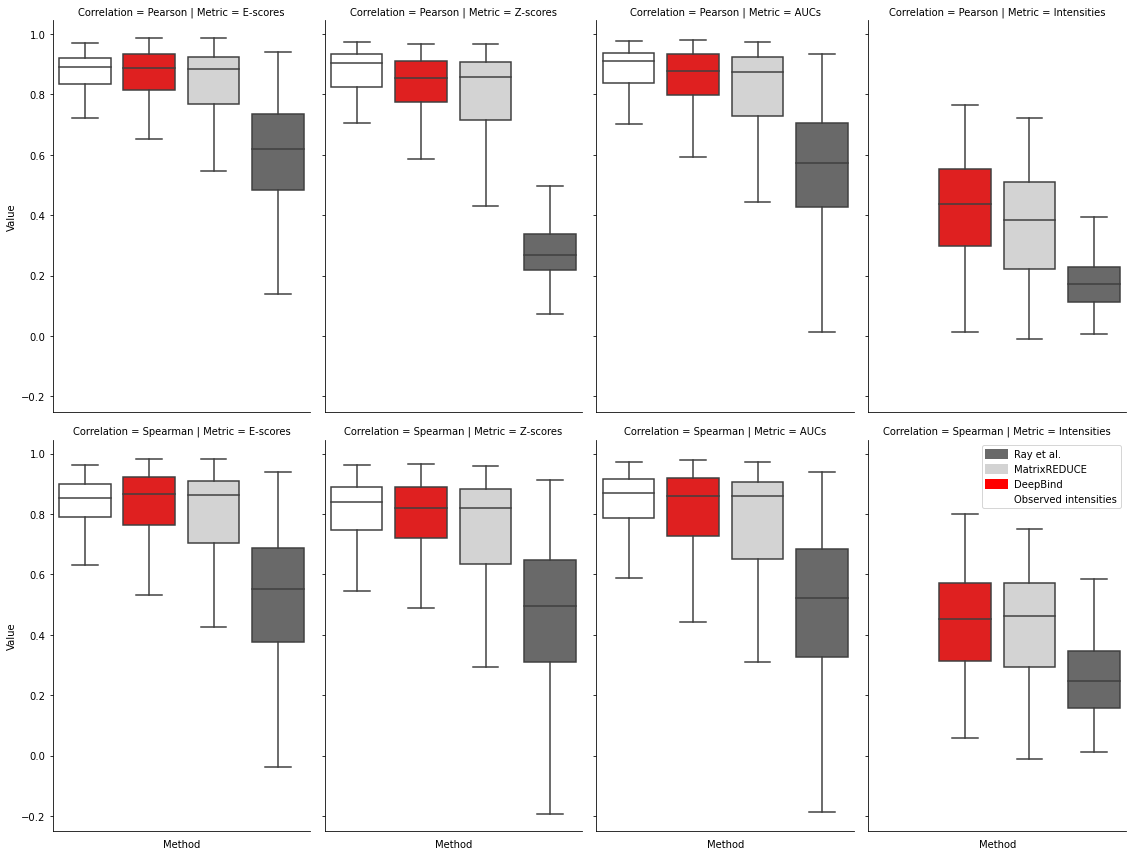

In [4]:
my_pal = {"Ray et al.": "dimgrey", "MatrixREDUCE": "lightgrey", "DeepBind": "red", "Observed intensities": "white"}
order = ["Observed intensities", "DeepBind", "MatrixREDUCE", "Ray et al."]
g = sns.FacetGrid(
    performance_summary, 
    row="Correlation", 
    col="Metric", 
    row_order=["Pearson", "Spearman"], 
    col_order=["E-scores", 
               "Z-scores", 
               "AUCs", 
               "Intensities"],
    height=6,
    aspect=0.66
)
g.map(sns.boxplot, "Method", "Value", palette=my_pal, order=order, showfliers = False)
patches = [matplotlib.patches.Patch(color=v, label=k, edgecolor="k", linewidth=3) for k,v in my_pal.items()]
plt.legend(handles=patches)
g.set(xticks=[])
g.fig.tight_layout()

# Performances from EUGENe

In [20]:
n_kmers = 1000
pearson_long = pd.DataFrame()
spearman_long = pd.DataFrame()
for method in ["setA", "ST", "MT", "kipoi"]:
    print(f"spearman/pearson_performance_{n_kmers}kmers_{method}.tsv")
    x_pearson = pd.read_csv(os.path.join(eu.settings.output_dir, f"pearson_performance_{n_kmers}kmers_{method}.tsv"), sep="\t")
    pearson_long = pd.concat([pearson_long, x_pearson], axis=0)
    x_spearman = pd.read_csv(os.path.join(eu.settings.output_dir, f"spearman_performance_{n_kmers}kmers_{method}.tsv"), sep="\t")
    spearman_long = pd.concat([spearman_long, x_spearman], axis=0)

spearman/pearson_performance_1000kmers_setA.tsv
spearman/pearson_performance_1000kmers_ST.tsv
spearman/pearson_performance_1000kmers_MT.tsv
spearman/pearson_performance_1000kmers_kipoi.tsv


In [21]:
# Convert my performances into the same format as the paper table above
spearman_df = spearman_long.pivot(index=['RBP', 'Metric'], columns='Model', values='Spearman').reset_index()
spearman_df["Correlation"] = "Spearman"
pearson_df = pearson_long.pivot(index=['RBP', 'Metric'], columns='Model', values='Pearson').reset_index()
pearson_df["Correlation"] = "Pearson"
trained_perfromance_df = pd.concat([pearson_df, spearman_df], axis=0)
trained_perfromance_df["Metric"] = trained_perfromance_df["Metric"].replace({"Z-score":"Z-scores", "AUC":"AUCs", "E-score":"E-scores", "Intensity": "Intensities"})
trained_perfromance_df.head()

Model,RBP,Metric,Kipoi,MultiTask,SetA,SingleTask,Correlation
0,RNCMPT00001,AUCs,0.875436,0.880180,0.921228,0.902033,Pearson
1,RNCMPT00001,E-scores,0.849183,0.871711,0.898422,0.889526,Pearson
2,RNCMPT00001,Intensities,0.551630,0.524309,NaN,0.440124,Pearson
3,RNCMPT00001,Z-scores,0.789533,0.861117,0.901047,0.861325,Pearson
4,RNCMPT00002,AUCs,0.750659,0.684231,0.819105,0.809154,Pearson


In [22]:
# Harmonize the paper table
paper_performance_df = performance_df.reset_index().rename({"index": "RBP"}, axis=1)
paper_performance_df.head()

NameError: name 'performance_df' is not defined

In [ ]:
# Make sure they have the same length
len(paper_performance_df), len(trained_perfromance_df)

(1952, 1952)

In [ ]:
# Create the aggregated table
full_performance_df = pd.merge(trained_perfromance_df, paper_performance_df, on=["RBP", "Metric", "Correlation"]).set_index("RBP")
full_performance_summary = full_performance_df.melt(id_vars=["Correlation", "Metric"], var_name="Method", value_name="Value")
full_performance_summary["Method"].value_counts()

Kipoi                   1952
MultiTask               1952
SetA                    1952
SingleTask              1952
Observed intensities    1952
DeepBind                1952
MatrixREDUCE            1952
Ray et al.              1952
Name: Method, dtype: int64

# Performance boxplot

/cellar/users/aklie/opt/miniconda3/envs/eugene_dev/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  app.launch_new_instance()


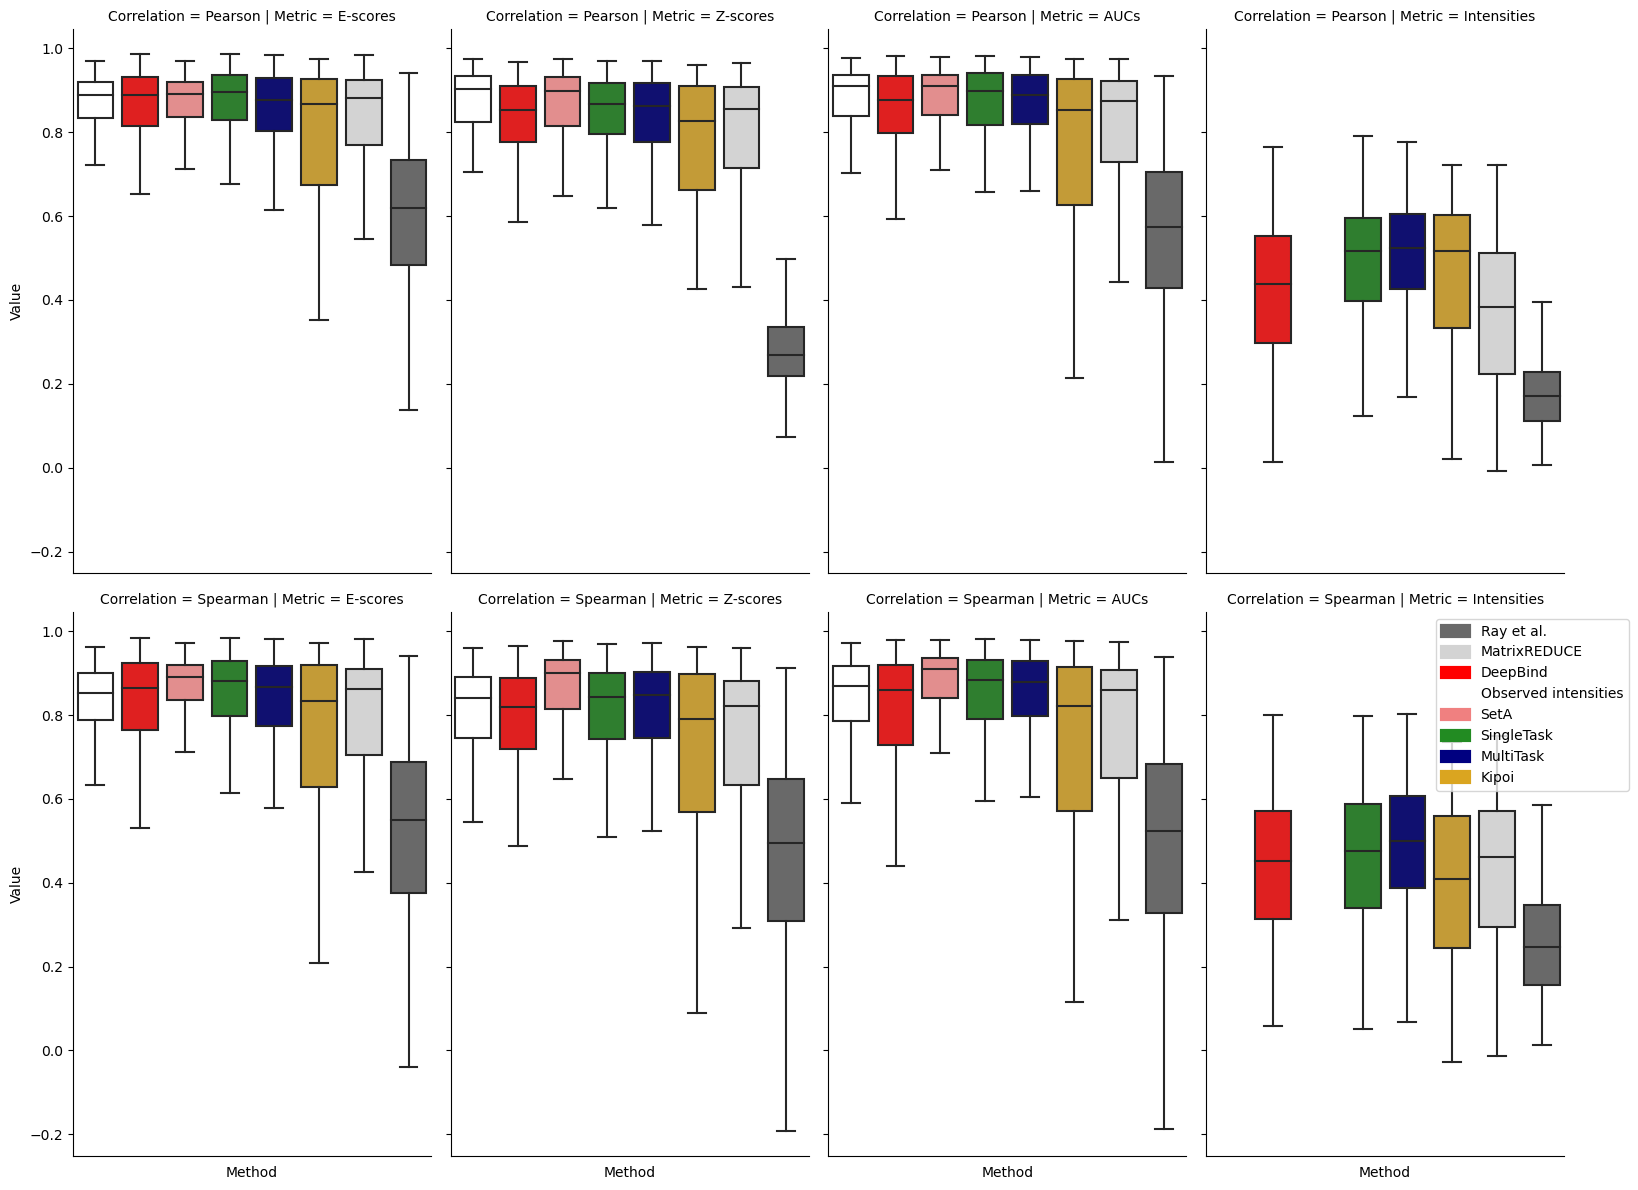

In [25]:
my_pal = {"Ray et al.": "dimgrey", "MatrixREDUCE": "lightgrey", "DeepBind": "red", "Observed intensities": "white",
         "SetA": "lightcoral", "SingleTask": "forestgreen", "MultiTask": "navy", "Kipoi": "goldenrod"}
order = ["Observed intensities", "DeepBind", "SetA", "SingleTask", "MultiTask", "Kipoi", "MatrixREDUCE", "Ray et al."]
g = sns.FacetGrid(
    full_performance_summary, 
    row="Correlation", 
    col="Metric", 
    row_order=["Pearson", "Spearman"], 
    col_order=["E-scores", 
               "Z-scores", 
               "AUCs", 
               "Intensities"],
    height=6,
    aspect=0.66
)
g.map(sns.boxplot, "Method", "Value", palette=my_pal, order=order, showfliers = False)
patches = [matplotlib.patches.Patch(color=v, label=k, edgecolor="k", linewidth=3) for k,v in my_pal.items()]
g.set(xticks=[])
g.fig.tight_layout()
plt.legend(handles=patches, loc='upper right', bbox_to_anchor=(1.2, 1))
plt.savefig(os.path.join(eu.settings.figure_dir, f"correlation_boxplots_{n_kmers}kmers_all.pdf"), dpi=300)

## Comparison scatterplots

In [10]:
# Helper function to plot the a line to apply to FacetGrid
def const_line(*args, **kwargs):
    x = np.arange(0, 1.01, 0.01)
    plt.plot(x, x, c='dimgrey', ls='--')

In [33]:
import itertools
order = ["SetA", "SingleTask", "MultiTask", "Kipoi", "Observed intensities", "DeepBind",  "MatrixREDUCE", "Ray et al."]
for method_x, method_y in list(itertools.combinations(order, 2)):
    g = sns.FacetGrid(full_performance_df, col="Metric", col_order=["Z-scores", "AUCs", "E-scores", "Intensities"])
    g.map(sns.scatterplot, method_x, method_y, s=10, color="royalblue", alpha=0.75, edgecolor="k", linewidth=0.3)
    g.map(const_line)
    method_x_save = method_x.replace(" ", "-").split(".")[0]
    method_y_save = method_y.replace(" ", "-").split(".")[0]
    plt.savefig(os.path.join(eu.settings.figure_dir, "scatterplot_comparisons", f"model_pearson_scatterplot_comparisons_{n_kmers}kmers_{method_x_save}_{method_y_save}.pdf"), dpi=300)
    plt.close()

# Best model intensity correlations

In [25]:
intensity_df = trained_perfromance_df[trained_perfromance_df["Metric"] == "Intensities"].set_index("RBP")

In [14]:
intensity_df["SingleTask"].sort_values(ascending=False)[:10].to_csv(os.path.join(eu.settings.output_dir, "top_10_ST_intensities.tsv"), sep="\t")

In [16]:
intensity_df["MultiTask"].sort_values(ascending=False)[:10].to_csv(os.path.join(eu.settings.output_dir, "top_10_MT_intensities.tsv"), sep="\t")

# TomTom Results

In [53]:
single_res = pd.read_csv(os.path.join(eu.settings.output_dir, "RNCMPT00023_filters_0.75_ST_tomtom.tsv"), sep="\t", index_col=0)

In [54]:
single_res_sig = single_res[single_res["q-value"] < 0.05].sort_values("q-value")

In [56]:
single_res_sig["Target_ID"].value_counts()

RNCMPT00045    2
RNCMPT00022    2
RNCMPT00023    2
RNCMPT00024    2
RNCMPT00113    1
RNCMPT00096    1
RNCMPT00153    1
RNCMPT00257    1
RNCMPT00253    1
RNCMPT00155    1
RNCMPT00064    1
RNCMPT00095    1
RNCMPT00094    1
RNCMPT00029    1
RNCMPT00052    1
RNCMPT00111    1
RNCMPT00056    1
RNCMPT00082    1
RNCMPT00044    1
RNCMPT00089    1
Name: Target_ID, dtype: int64

In [7]:
multi_res = pd.read_csv(os.path.join(eu.settings.output_dir, "filters_0.75_MT_tomtom.tsv"), sep="\t", comment="#")

In [9]:
multi_res_sig = multi_res[multi_res["q-value"] < 0.05].sort_values("q-value")

In [18]:
multi_res_sig[multi_res_sig["Target_ID"] == "RNCMPT00023"]

,Query_ID,Target_ID,Optimal_offset,p-value,E-value,q-value,Overlap,Query_consensus,Target_consensus,Orientation
9468,filter842,RNCMPT00023,0,0.000105,0.025662,0.011865,7,UUAGGGAAUAAGAUGC,UUAGGGA,+


In [15]:
len(multi_res_sig["Target_ID"].unique())

153

In [40]:
intensity_df = trained_perfromance_df[(trained_perfromance_df["Metric"] == "Z-scores") & (trained_perfromance_df["Correlation"] == "Pearson")]

In [41]:
mt_intensity = intensity_df.set_index("RBP")["MultiTask"]

In [64]:
filter_val_counts = pd.DataFrame(multi_res_sig.value_counts("Target_ID")).astype(int)

In [65]:
filter_val_counts.columns = ["num_sig_filters"]

In [66]:
df = pd.concat([mt_intensity, filter_val_counts], axis=1).dropna()

/cellar/users/aklie/opt/miniconda3/envs/eugene_dev/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='MultiTask', ylabel='num_sig_filters'>

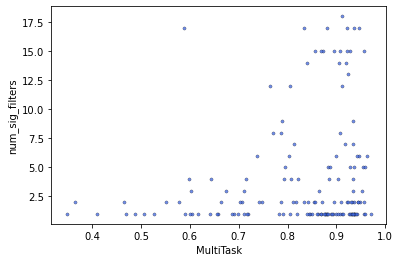

In [67]:
sns.scatterplot(df["MultiTask"], df["num_sig_filters"], s=10, color="royalblue", alpha=0.75, edgecolor="k", linewidth=0.3)

In [70]:
df["num_sig_filters"] = df["num_sig_filters"].astype(int)

In [72]:
df["num_sig_filters"]

RNCMPT00003     1
RNCMPT00004     1
RNCMPT00005    15
RNCMPT00011     1
RNCMPT00012    14
               ..
RNCMPT00281     1
RNCMPT00283     2
RNCMPT00285     3
RNCMPT00288     1
RNCMPT00289     1
Name: num_sig_filters, Length: 147, dtype: int64

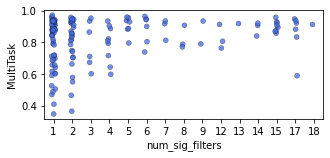

In [84]:
fig, ax = plt.subplots(figsize=(5, 2))
sns.stripplot(data=df, x="num_sig_filters", y="MultiTask", color="royalblue", alpha=0.75, edgecolor="k", linewidth=0.3)
plt.savefig(os.path.join(eu.settings.figure_dir, "num_sig_filters_vs_MT_intensity.pdf"), dpi=300)

In [17]:
"RNCPT00215" in multi_res_sig["Target_ID"].unique()

False

<AxesSubplot:ylabel='Target_ID'>

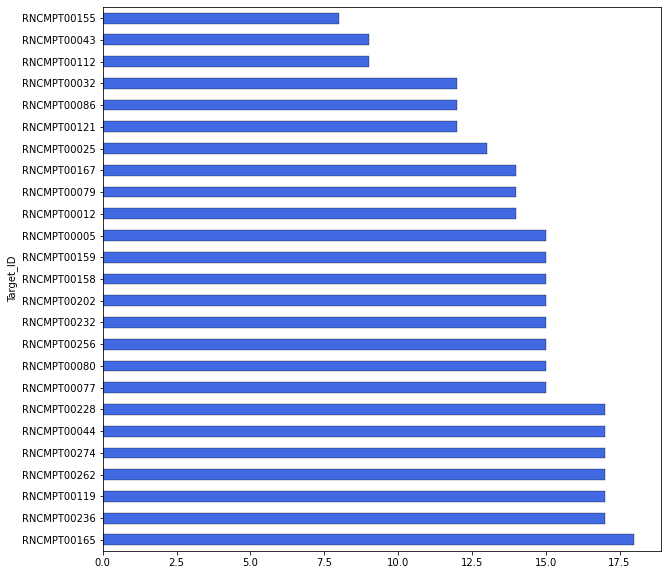

In [11]:
multi_res_sig.value_counts("Target_ID").iloc[:25].plot.barh(figsize=(10, 10), color="royalblue", edgecolor="k", linewidth=0.3)

In [75]:
sdata_test = eu.dl.read_h5sd(os.path.join(eu.settings.output_dir, "norm_test_predictions_and_intepretations_noMTfilters_0.75.h5sd"))

In [77]:
sdata_test

SeqData object with = 121031 seqs
seqs = (121031,)
names = (121031,)
rev_seqs = None
ohe_seqs = (121031, 4, 41)
ohe_rev_seqs = None
seqs_annot: 'Probe_Set', 'RNCMPT00001', 'RNCMPT00002', 'RNCMPT00003', 'RNCMPT00004', 'RNCMPT00005', 'RNCMPT00006', 'RNCMPT00007', 'RNCMPT00008', 'RNCMPT00009', 'RNCMPT00010', 'RNCMPT00011', 'RNCMPT00012', 'RNCMPT00013', 'RNCMPT00014', 'RNCMPT00015', 'RNCMPT00016', 'RNCMPT00017', 'RNCMPT00018', 'RNCMPT00019', 'RNCMPT00020', 'RNCMPT00021', 'RNCMPT00022', 'RNCMPT00023', 'RNCMPT00024', 'RNCMPT00025', 'RNCMPT00026', 'RNCMPT00027', 'RNCMPT00028', 'RNCMPT00029', 'RNCMPT00031', 'RNCMPT00032', 'RNCMPT00033', 'RNCMPT00034', 'RNCMPT00035', 'RNCMPT00036', 'RNCMPT00037', 'RNCMPT00038', 'RNCMPT00039', 'RNCMPT00040', 'RNCMPT00041', 'RNCMPT00042', 'RNCMPT00043', 'RNCMPT00044', 'RNCMPT00045', 'RNCMPT00046', 'RNCMPT00047', 'RNCMPT00049', 'RNCMPT00050', 'RNCMPT00051', 'RNCMPT00052', 'RNCMPT00053', 'RNCMPT00054', 'RNCMPT00055', 'RNCMPT00056', 'RNCMPT00057', 'RNCMPT00058', 'RN

In [79]:
sdata_test.uns["pfms_RNCMPT00023_ST"]

array([[[2.16560510e-02, 8.92993631e-01, 4.58598726e-02, 3.94904459e-02],
        [5.60509554e-02, 6.14012739e-01, 2.91719745e-01, 3.82165605e-02],
        [2.10191083e-01, 5.22292994e-01, 4.58598726e-02, 2.21656051e-01],
        ...,
        [6.58108108e-01, 1.17567568e-01, 4.05405405e-03, 2.20270270e-01],
        [9.36170213e-02, 4.15602837e-01, 3.02127660e-01, 1.88652482e-01],
        [3.60983103e-01, 3.27188940e-01, 1.78187404e-01, 1.33640553e-01]],

       [[6.34883721e-01, 1.75968992e-01, 1.61240310e-01, 2.79069767e-02],
        [1.08191654e-01, 7.78207110e-01, 3.16846986e-02, 8.19165379e-02],
        [7.18701700e-02, 7.47295209e-01, 8.11437403e-02, 9.96908810e-02],
        ...,
        [0.00000000e+00, 3.68421053e-01, 6.20900076e-01, 1.06788711e-02],
        [6.28834356e-02, 3.02914110e-01, 6.26533742e-01, 7.66871166e-03],
        [4.78056426e-02, 7.60188088e-01, 1.77899687e-01, 1.41065831e-02]],

       [[3.40537001e-02, 2.03012443e-01, 4.07989522e-01, 3.54944335e-01],
        

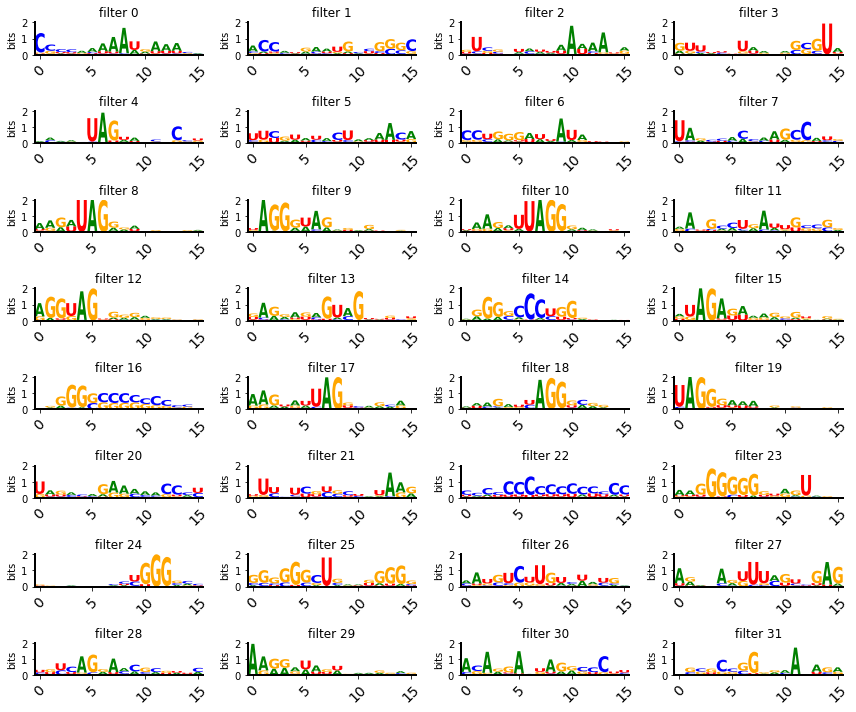

In [82]:
eu.pl.lm_multifilter_viz(
    sdata_test,
    filter_ids=range(0,32),
    uns_key="pfms_RNCMPT00023_ST",
    titles=[f"filter {i}" for i in range(32)],
    vocab="RNA",
    num_rows=8,
    num_cols=4,
    save=os.path.join(eu.settings.figure_dir, "filter_viz", "filters_viz_RNCMPT00023_0.75_ST.pdf")
)


---

# Scratch 

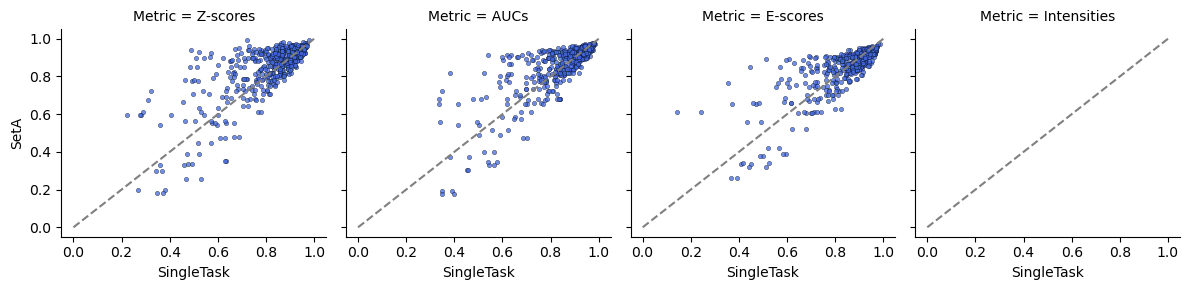

In [ ]:
# Plot the evaluation metrics comparisons for single task vs SetA Pearson correlation
g = sns.FacetGrid(full_performance_df, col="Metric", col_order=["Z-scores", "AUCs", "E-scores", "Intensities"])
g.map(sns.scatterplot, "SingleTask", "SetA", s=10, color="royalblue", alpha=0.75, edgecolor="k", linewidth=0.3)
g.map(const_line)
plt.savefig(os.path.join(eu.settings.figure_dir, "model_pearson_scatterplot_comparisons_ST_setA_.pdf"))

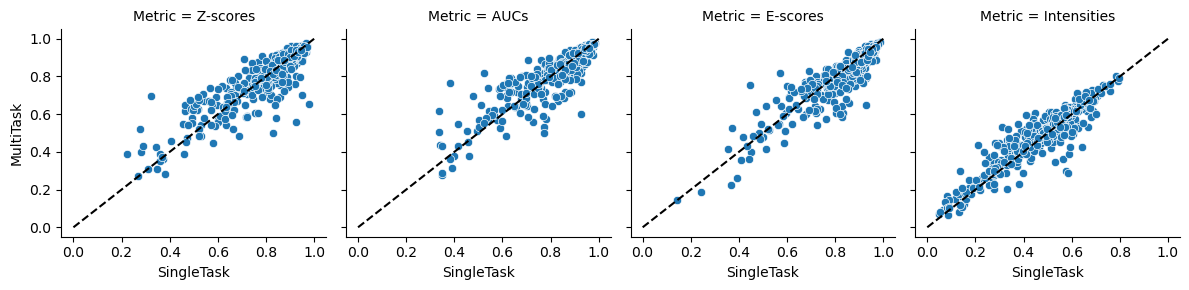

In [ ]:
# Plot the evaluation metrics comparisons for single task vs SetA Pearson correlation
g = sns.FacetGrid(full_performance_df, col="Metric", col_order=["Z-scores", "AUCs", "E-scores", "Intensities"])
g.map(sns.scatterplot, "SingleTask", "MultiTask", s=10, color="royalblue", alpha=0.75, edgecolor="k", linewidth=0.3)
g.map(const_line)
#plt.savefig(os.path.join(figure_dir, "model_pearson_scatterplot_comparisons_ST_setA_.pdf"))

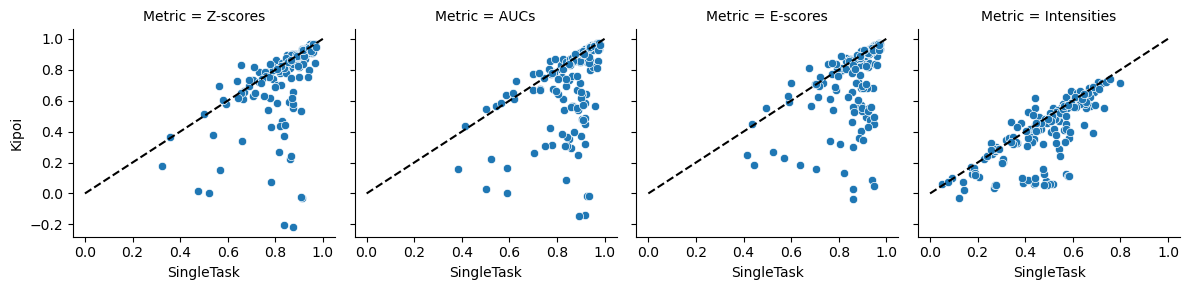

In [ ]:
# Plot the evaluation metrics comparisons for single task vs SetA Pearson correlation
g = sns.FacetGrid(full_performance_df, col="Metric", col_order=["Z-scores", "AUCs", "E-scores", "Intensities"])
g.map(sns.scatterplot, "SingleTask", "Kipoi")
g.map(const_line)
#plt.savefig(os.path.join(figure_dir, "model_pearson_scatterplot_comparisons_ST_setA_.pdf"))

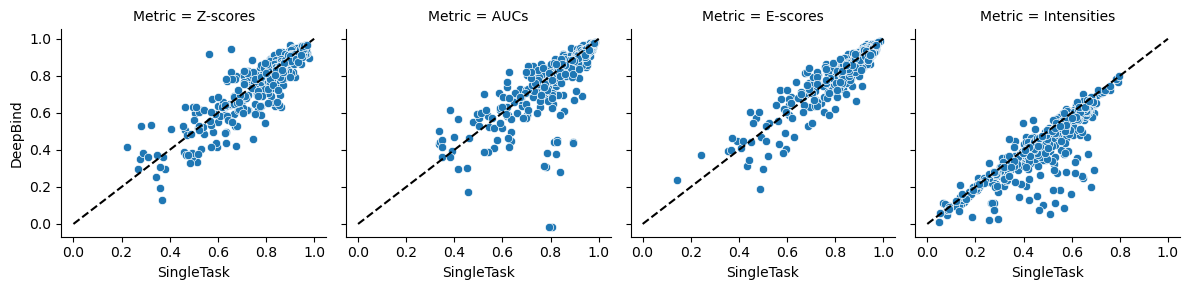

In [ ]:
# Plot the evaluation metrics comparisons for single task vs SetA Pearson correlation
g = sns.FacetGrid(full_performance_df, col="Metric", col_order=["Z-scores", "AUCs", "E-scores", "Intensities"])
g.map(sns.scatterplot, "SingleTask", "DeepBind")
g.map(const_line)
#plt.savefig(os.path.join(figure_dir, "model_pearson_scatterplot_comparisons_ST_setA_.pdf"))

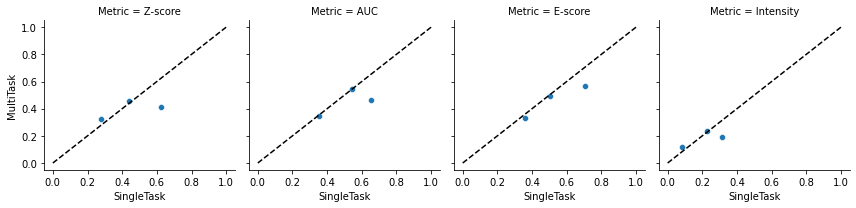

In [ ]:
# Plot the evaluation metrics comparisons for single task vs multitask using Pearson correlation
g = sns.FacetGrid(pearson_models, col="Metric", col_order=["Z-score", "AUC", "E-score", "Intensity"])
g.map(sns.scatterplot, "SingleTask", "MultiTask")
g.map(const_line)
plt.savefig(os.path.join(figure_dir, "model_pearson_scatterplot_comparisons_ST_MT.pdf"))

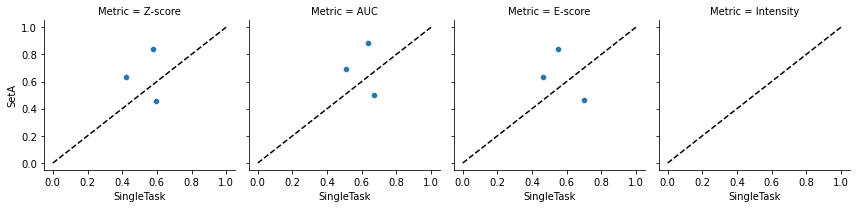

In [ ]:
# Plot the evaluation metrics comparisons for single task vs SetA using Spearman correlation
g = sns.FacetGrid(spearman_models, col="Metric", col_order=["Z-score", "AUC", "E-score", "Intensity"])
g.map(sns.scatterplot, "SingleTask", "SetA")
g.map(const_line)
plt.savefig(os.path.join(figure_dir, "model_spearman_scatterplot_comparisons_ST_setA.pdf"))

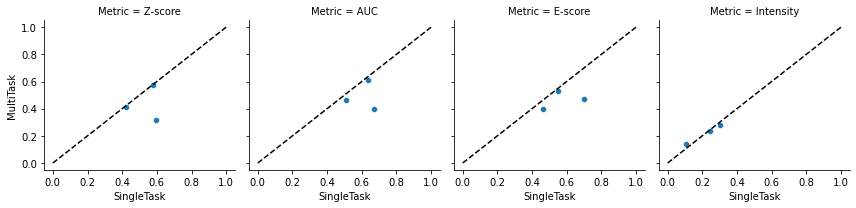

In [ ]:
# Plot the evaluation metrics comparisons for single task vs multitask using Spearman correlation
g = sns.FacetGrid(spearman_models, col="Metric", col_order=["Z-score", "AUC", "E-score", "Intensity"])
g.map(sns.scatterplot, "SingleTask", "MultiTask")
g.map(const_line)
plt.savefig(os.path.join(figure_dir, "model_spearman_scatterplot_comparisons_ST_MT.pdf"))

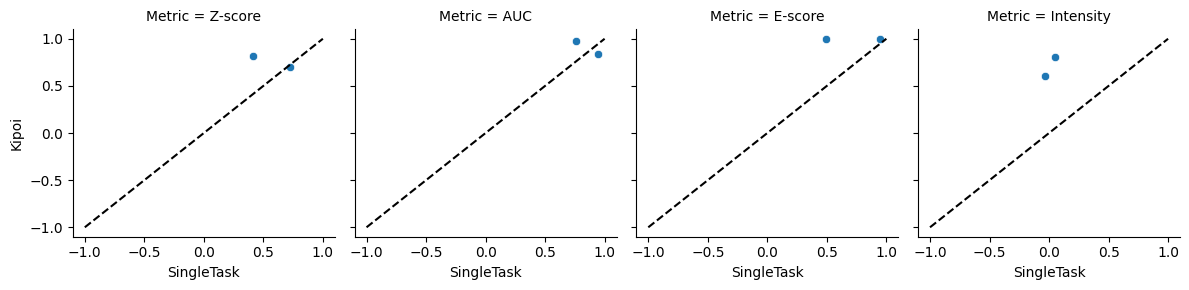

In [ ]:
# Plot the Pearson correlations comparisons between single task vs kipoi
g = sns.FacetGrid(pearson_models, col="Metric", col_order=["Z-score", "AUC", "E-score", "Intensity"])
g.map(sns.scatterplot, "SingleTask", "Kipoi")
g.map(const_line)
plt.savefig(os.path.join(figure_dir, "model_pearson_scatterplot_comparisons_ST_kipoi.pdf"))

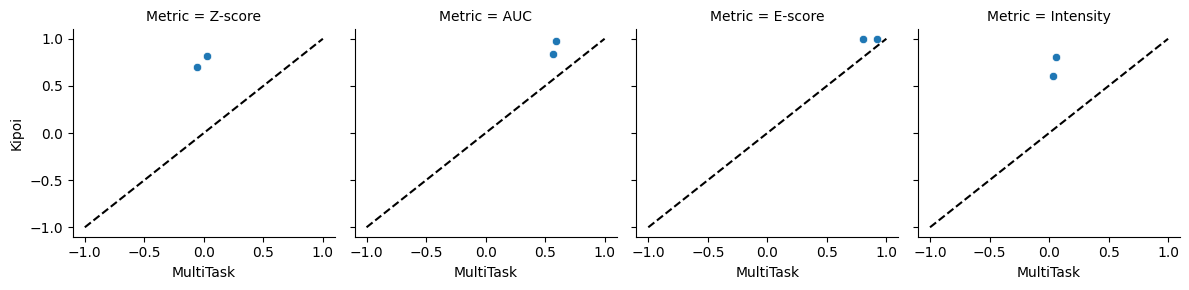

In [ ]:
# Plot the Pearson correlations comparisons between multitask vs kipoi
g = sns.FacetGrid(pearson_models, col="Metric", col_order=["Z-score", "AUC", "E-score", "Intensity"])
g.map(sns.scatterplot, "MultiTask", "Kipoi")
g.map(const_line)
plt.savefig(os.path.join(figure_dir, "model_pearson_scatterplot_comparisons_MT_kipoi.pdf"))

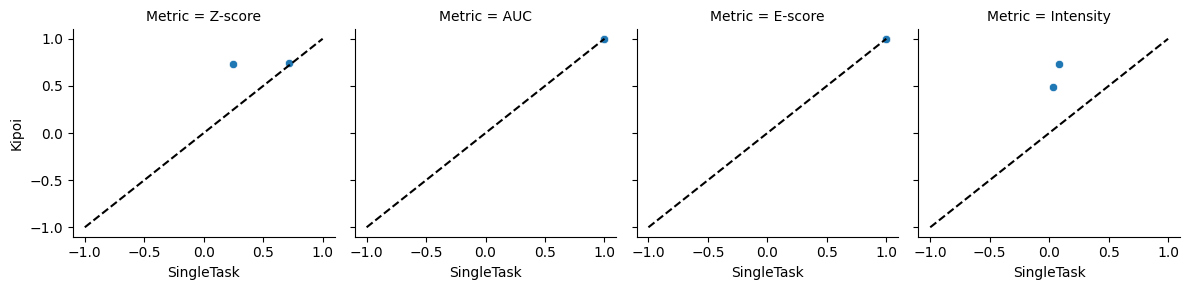

In [ ]:
# Plot the Spearman correlations comparisons between single task vs kipoi
g = sns.FacetGrid(spearman_models, col="Metric", col_order=["Z-score", "AUC", "E-score", "Intensity"])
g.map(sns.scatterplot, "SingleTask", "Kipoi")
g.map(const_line)
plt.savefig(os.path.join(figure_dir, "model_spearman_scatterplot_comparisons_ST_kipoi.pdf"))

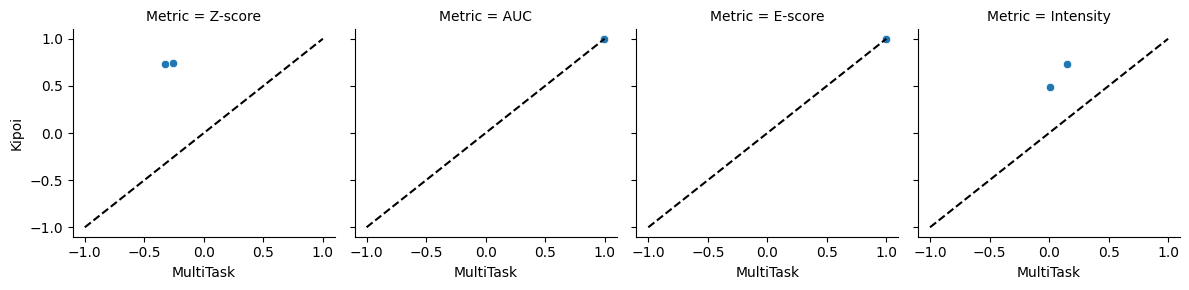

In [ ]:
# Plot the Spearman correlations comparisons between multitask vs kipoi
g = sns.FacetGrid(spearman_models, col="Metric", col_order=["Z-score", "AUC", "E-score", "Intensity"])
g.map(sns.scatterplot, "MultiTask", "Kipoi")
g.map(const_line)
plt.savefig(os.path.join(figure_dir, "model_spearman_scatterplot_comparisons_MT_kipoi.pdf"))

In [47]:
model = kipoi.get_model('DeepBind/Homo_sapiens/RBP/D00084.001_RNAcompete_A1CF').model
model.summary()

Using downloaded and verified file: /home/vscode/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00084.001_RNAcompete_A1CF/arch/127f7597630be937c0495a27e6f42e5f
Using downloaded and verified file: /home/vscode/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00084.001_RNAcompete_A1CF/weights/a4caf255312f44e3fd4e038a79691f2d
Model: "model_94"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_94 (InputLayer)          [(None, None, 4)]    0           []                               
                                                                                                  
 lambda_276 (Lambda)            (None, None, 4)      0           ['input_94[0][0]']               
                                                                                                  
 conv1d_94 (Conv1D)            

2022-09-04 00:29:07.587119: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open /home/vscode/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00084.001_RNAcompete_A1CF/weights/a4caf255312f44e3fd4e038a79691f2d: DATA_LOSS: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


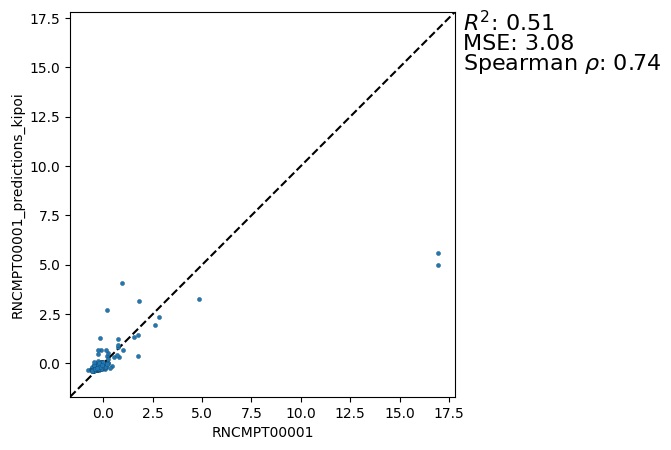

In [31]:
eu.pl.performance_scatter(
    sdata_test,
    target_cols[0],
    f"{target_cols[0]}_predictions_kipoi",
    figsize=(5, 5),
)

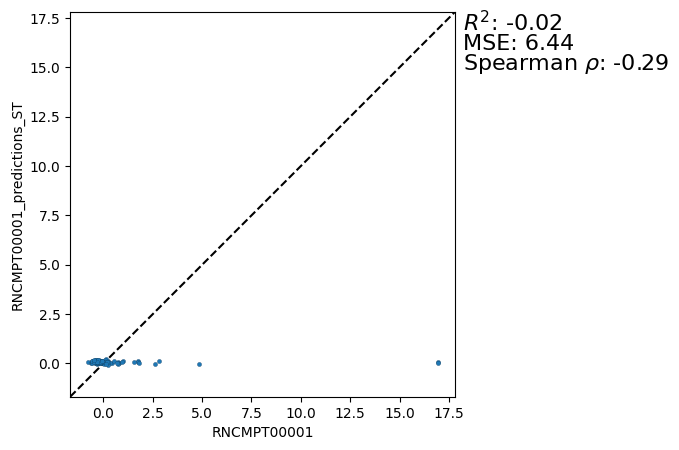

In [34]:
eu.pl.performance_scatter(
    sdata_test,
    target_cols[0],
    f"{target_cols[0]}_predictions_ST",
    figsize=(5, 5),
)

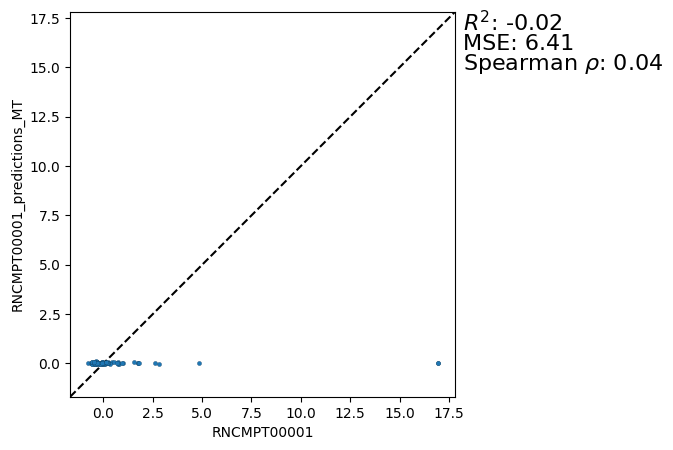

In [33]:
eu.pl.performance_scatter(
    sdata_test,
    target_cols[0],
    f"{target_cols[0]}_predictions_MT",
    figsize=(5, 5),
)

In [29]:
sdata_test

SeqData object with = 100 seqs
seqs = (100,)
names = (100,)
rev_seqs = None
ohe_seqs = (100, 41, 4)
ohe_rev_seqs = None
seqs_annot: 'Probe_Set', 'RNCMPT00001', 'RNCMPT00001_predictions_MT', 'RNCMPT00001_predictions_ST', 'RNCMPT00002', 'RNCMPT00002_predictions_MT', 'RNCMPT00002_predictions_ST', 'RNCMPT00003', 'RNCMPT00003_predictions_MT', 'RNCMPT00003_predictions_ST', 'RNCMPT00004', 'RNCMPT00004_predictions_MT', 'RNCMPT00004_predictions_ST', 'RNCMPT00005', 'RNCMPT00005_predictions_MT', 'RNCMPT00005_predictions_ST', 'RNCMPT00006', 'RNCMPT00006_predictions_MT', 'RNCMPT00007', 'RNCMPT00007_predictions_MT', 'RNCMPT00008', 'RNCMPT00009', 'RNCMPT00010', 'RNCMPT00010_predictions_MT', 'RNCMPT00011', 'RNCMPT00011_predictions_MT', 'RNCMPT00012', 'RNCMPT00012_predictions_MT', 'RNCMPT00013', 'RNCMPT00013_predictions_MT', 'RNCMPT00014', 'RNCMPT00014_predictions_MT', 'RNCMPT00015', 'RNCMPT00016', 'RNCMPT00016_predictions_MT', 'RNCMPT00017', 'RNCMPT00017_predictions_MT', 'RNCMPT00018', 'RNCMPT00018_pr

In [24]:
sdata_test["RNCMPT00001"].values

array([-3.27493065e-01, -3.42261224e-01,  1.93591734e-01,  1.73070340e+00,
       -8.22276870e-02, -3.87272678e-03, -8.00605627e-01,  7.51865532e-01,
       -1.84364492e-02, -1.90977154e-01, -6.11971428e-01,  1.69336841e+01,
       -1.50286938e-01,  4.15017634e-01, -3.44858715e-01,  8.02916737e-01,
       -8.69724004e-02, -2.55419595e-01,  2.21111708e-01, -2.52743450e-01,
        9.75111618e-01, -5.56894859e-01,  2.17765571e-01,  9.40233517e-01,
       -1.17495874e-01, -2.20792741e-01, -3.07698375e-01, -3.35112310e-01,
                   nan,  2.80191096e+00, -4.30429143e-01,  1.73595124e+00,
       -4.14881768e-01,  1.30148548e-01, -3.21330673e-02, -2.34298934e-01,
       -4.13446572e-01,  2.53961042e-02,  1.54145652e-01, -3.14702400e-01,
       -3.93914593e-01,  1.26059497e-01, -5.08499739e-01, -5.71038245e-01,
       -1.16288360e-01, -3.65702018e-01,  5.31071407e-02,  3.11713442e-01,
       -4.44369047e-01,  7.26077537e-01, -5.90690279e-02, -4.74033695e-01,
        5.54652000e-01, -